In [ ]:
pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"omareldamrany","key":"1b981ce345a7f4a1189ef6e78cd1b4da"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

In [ ]:
! kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 98% 664M/675M [00:02<00:00, 273MB/s]
100% 675M/675M [00:02<00:00, 260MB/s]


In [ ]:
!unzip cell-images-for-detecting-malaria

In [276]:
import shutil

shutil.rmtree('/content/Data/parasitized')
shutil.rmtree('/content/Data/uninfected')

In [ ]:
import os 
import cv2
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
from PIL import Image
import glob as gb
import shutil
import csv
from scipy.stats import skew,kurtosis,entropy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import img_to_array

In [277]:
!mkdir /content/Data
!mkdir /content/Data/parasitized
!mkdir /content/Data/uninfected 

#getting paths of both classes
parasitized_path = '/content/cell_images/Parasitized'
uninfected_path = '/content/cell_images/Uninfected'

#taking 500 photos only from each directory 

c=0
src_dir = "/content/cell_images/Parasitized"
dst_dir = "/content/Data/parasitized"
for jpgfile in gb.iglob(os.path.join(src_dir, "*.png")):
    if (c<3000):
      shutil.copy(jpgfile, dst_dir)
      c += 1
    else :
      break
c=0
src_dir = "/content/cell_images/Uninfected"
dst_dir = "/content/Data/uninfected"
for jpgfile in gb.iglob(os.path.join(src_dir, "*.png")):
    if (c<3000):
      shutil.copy(jpgfile, dst_dir)
      c += 1
    else :
      break

mkdir: cannot create directory ‘/content/Data’: File exists


In [278]:
parasitized_path = '/content/Data/parasitized'
uninfected_path = '/content/Data/uninfected'

f = open('/content/features_extracted.csv','w',newline='')
writer = csv.writer(f)
title = ['binary_green Mean','Median','Variance','STD','green_diff Mean','Median','Variance','STD','Label'] # 0 --> parasitized 1 --> uninfected
writer.writerow(title)

parasitized_data=[]
uninfected_data=[]

# features extraction process


#parasitized
label = parasitized_path.split('/')[-1]

for image in os.listdir(parasitized_path):
  extracted_features = []
  img = cv2.imread(os.path.join(parasitized_path,image), cv2.IMREAD_COLOR)
  img = cv2.resize(img, (100,100))
 
  binary_mask = cv2.split(img)[0]
  ret , binary_mask = cv2.threshold(binary_mask, 10, 255, cv2.THRESH_BINARY)
  ret, binary_green = cv2.threshold(cv2.split(img)[1], 100, 255, cv2.THRESH_BINARY)
  kernel = np.ones((3,3),np.uint8)

  binary_mask = cv2.erode(binary_mask, kernel, iterations = 1)
  infection = cv2.subtract(binary_mask, binary_green)

  img_array = img_to_array(binary_green)
  parasitized_data.append(img_array)



  extracted_features.append(np.mean(binary_green))
  extracted_features.append(np.median(binary_green))
  extracted_features.append(np.var(binary_green, dtype= np.float32))
  extracted_features.append(np.std(binary_green))

  extracted_features.append(np.mean(infection))
  extracted_features.append(np.median(infection))
  extracted_features.append(np.var(infection, dtype= np.float32))
  extracted_features.append(np.std(infection))
  extracted_features.append(0)
  writer.writerow(extracted_features)

#uninfected  
label = uninfected_path.split('/')[-1]
for image in os.listdir(uninfected_path):
  extracted_features = []
  img = cv2.imread(os.path.join(uninfected_path,image))
  img_gray = cv2.cvtColor (img,cv2.COLOR_RGB2GRAY)
  img = cv2.resize(img, (100,100))
  img_gray = cv2.resize(img_gray, (100,100))

  binary_mask = cv2.split(img)[0]
  ret , binary_mask = cv2.threshold(binary_mask, 10, 255, cv2.THRESH_BINARY)
  ret, binary_green = cv2.threshold(cv2.split(img)[1], 100, 255, cv2.THRESH_BINARY)
  kernel = np.ones((3,3),np.uint8)

  binary_mask = cv2.erode(binary_mask, kernel, iterations = 1)
  infection = cv2.subtract(binary_mask, binary_green)

  img_array = img_to_array(binary_green)
  uninfected_data.append(img_array)

  extracted_features.append(np.mean(binary_green))
  extracted_features.append(np.median(binary_green))
  extracted_features.append(np.var(binary_green, dtype= np.float32))
  extracted_features.append(np.std(binary_green))

  extracted_features.append(np.mean(infection))
  extracted_features.append(np.median(infection))
  extracted_features.append(np.var(infection, dtype= np.float32))
  extracted_features.append(np.std(infection))
  extracted_features.append(1)
  writer.writerow(extracted_features)

f.close()


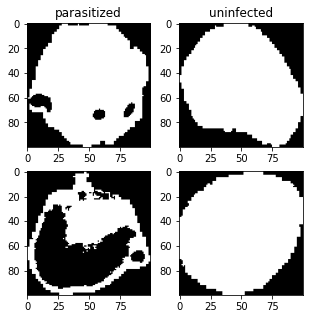

In [173]:
#visual comparison between parasitized vs uninfected malaria cell

p = parasitized_data[0]
u = uninfected_data[1]

p2 = parasitized_data[10]
u2 = uninfected_data[10]

f, axarr = plt.subplots(2,2, figsize=(5,5))
axarr[0,0].set_title('parasitized')
axarr[0,0].imshow(p[:,:,0], cmap='gray')
axarr[0,1].set_title('uninfected')
axarr[0,1].imshow(u[:,:,0], cmap='gray')
axarr[1,0].imshow(p2[:,:,0], cmap='gray')
axarr[1,1].imshow(u2[:,:,0], cmap='gray')


In [174]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from numpy import loadtxt

In [279]:
#load csv file and shuffle 
dataset = loadtxt('/content/features_extracted.csv',skiprows=1 ,delimiter=',')
np.random.shuffle(dataset)

In [280]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset, test_size=0.3, random_state=42)

#get features from csv file as x and get labels as y 
x_train = train[:,0:8]
y_train = train[:,8]
x_test = test[:,0:8]
y_test = test[:,8]

#adding layers 
model = Sequential()
model.add(Dense(12, input_shape=(8,), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 12)                108       
                                                                 
 dense_46 (Dense)            (None, 8)                 104       
                                                                 
 dense_47 (Dense)            (None, 1)                 9         
                                                                 
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________


In [281]:
#train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=10)

Epoch 1/10
420/420 [==============================] - 1s 1ms/step - loss: 1.0375 - accuracy: 0.8838
Epoch 2/10
420/420 [==============================] - 0s 1ms/step - loss: 0.2557 - accuracy: 0.9283
Epoch 3/10
420/420 [==============================] - 0s 1ms/step - loss: 0.2400 - accuracy: 0.9317
Epoch 4/10
420/420 [==============================] - 0s 1ms/step - loss: 0.2474 - accuracy: 0.9205
Epoch 5/10
420/420 [==============================] - 0s 1ms/step - loss: 0.2365 - accuracy: 0.9352
Epoch 6/10
420/420 [==============================] - 0s 1ms/step - loss: 0.2273 - accuracy: 0.9390
Epoch 7/10
420/420 [==============================] - 0s 1ms/step - loss: 0.2347 - accuracy: 0.9340
Epoch 8/10
420/420 [==============================] - 0s 1ms/step - loss: 0.2233 - accuracy: 0.9388
Epoch 9/10
420/420 [==============================] - 0s 1ms/step - loss: 0.2168 - accuracy: 0.9417
Epoch 10/10
420/420 [==============================] - 0s 1ms/step - loss: 0.2197 - accuracy: 0.9400

In [282]:
#evaluate model and test it
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test loss: %.2f' % test_loss)
print('Test Accuracy: %.2f' % (test_acc*100))

y_pred = model.predict(x_test)
y_pred = (model.predict(x_test) > 0.5).astype(int)


57/57 [==============================] - 0s 1ms/step - loss: 0.3006 - accuracy: 0.9217
Test loss: 0.30
Test Accuracy: 92.17
57/57 [==============================] - 0s 844us/step


In [283]:
#predictions
correct=0
for i in range(len(y_test)):
 if y_pred[i]== y_test[i]:
   correct=correct+1
print('number of correct prediction', correct ,'from', len(y_test))

number of correct prediction 1659 from 1800


[[856  54]
 [ 87 803]]


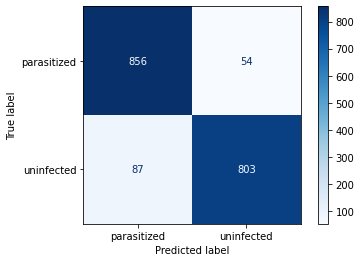

In [284]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

#confuision matrix to see the TP,TN,FP,FN
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

disp = ConfusionMatrixDisplay(confusion_matrix= conf_mat, display_labels=["parasitized", "uninfected"])
disp = disp.plot(cmap=plt.cm.Blues, values_format = 'g')

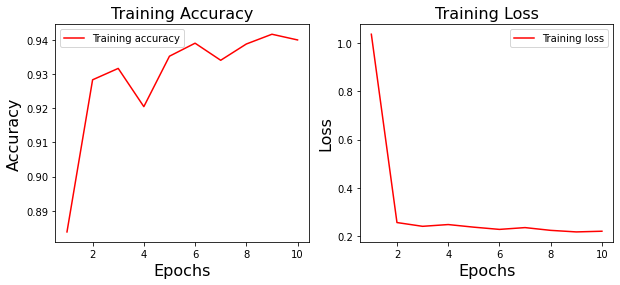

In [285]:
history_dict = history.history
loss_values = history_dict['loss']
accuracy = history_dict['accuracy']

 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plot the model accuracy vs Epochs

ax[0].plot(epochs, accuracy, 'r', label='Training accuracy')

ax[0].set_title('Training Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()

# Plot the loss vs Epochs

ax[1].plot(epochs, loss_values, 'r', label='Training loss')
ax[1].set_title('Training Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()